In [32]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [33]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [34]:
k = 10 # Top 10% highest l2-magnitude filters

 ============ LAYER 0 ==================
[10, 45, 51, 0, 47, 62, 3, 37, 58, 26]
(3, 3, 3, 10)
(10, 3, 3, 3) (10, 3, 3, 3) (10, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
[4.06785272e-05 1.29375483e-02] [[-0.99916727 -0.0408015 ]
 [-0.0408015   0.99916727]]
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
[3.80029822e-07 1.82514378e-02] [[ 0.59509626 -0.80365443]
 [-0.80365443 -0.59509626]]
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
[4.20290957e-05 1.91781074e-02] [[-0.17545003 -0.98448834]
 [-0.98448834  0.17545003]]
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
[1.82804743e-06 1.31224481e-02] [[-0.65280826 -0.75752318]
 [-0.75752318  0.65280826]]
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
[2.68999591e-06 1.36922896e-02] [[-0.8472386  -0.53121253]
 [-0.53121253  0.8472386 ]]
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
[4.55160824e-05 1.04840765e-02] [[ 0.6169765  -0.78698157]
 [-0.78698157 -0.6169765 ]]
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
[3.36581849e-05 8.04423906e-03] [[-0.96721901 -0.25394368]
 [-0.25394

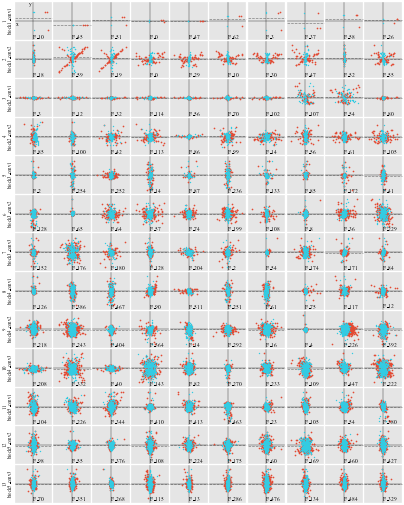

In [38]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '50'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []

fig= plt.figure(figsize = (10,13))
fig.clf()
#fig.tight_layout()
gs1 = gridspec.GridSpec(len(conv_layers), 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (len(conv_layers), 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)



#fig.set_tight_layout(True)
for l_num, l in enumerate(conv_layers):
	print(f" ============ LAYER {l_num} ==================")
	top10F=topKfilters(model, l_num, k=100)[:10]
	print(top10F[:10])
	filters = get_filter(model, l_num)[:,:,:, top10F]
	theta = getSobelTF(filters)
	print(filters.shape)
	s, a = getSymAntiSymTF(filters)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])
	s_mag = reduce_euclidean_norm(s, axis=[0,1])
	dc = np.sign(reduce_mean(s, axis=[0,1]))


	for i in range(10):
		
		x =a_mag[:,i]*np.cos((theta[:,i]))
		y = a_mag[:,i]*np.sin((theta[:,i]))
		#c,s = mean_direction(theta[:,i], a_mag[:,i])
		#print(d)


		dvec, dtheta = getDominantAngle(tf.expand_dims(filters[:,:, :,i], -1))

		#c,s = mean_direction(theta[:,i], a_mag[:,i])
		#print(d)
		lim_x = np.max(np.abs(a_mag[:,i]))
		lim_y = np.max(np.abs( s_mag[:,i]))
		lim = np.max([lim_x, lim_y])
		lim *= 1.3

		e_vec1 = dvec[0]  #Major
		e_vec2 = [-e_vec1[1], e_vec1[0]]

		fa1 = tf.tensordot(tf.stack([x,y], axis=1) , e_vec1, axes=1) / tf.math.reduce_euclidean_norm(e_vec1) #filter projected onto Major Axis
		fa2 = tf.tensordot(tf.stack([x,y], axis=1) , e_vec2, axes=1) / tf.math.reduce_euclidean_norm(e_vec2) #filter projected onto Minor Axis

		#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
		ax[l_num, i].set_xlim(-lim, lim)
		ax[l_num, i].set_ylim(-lim, lim)

		'''ax[l_num, i].spines['right'].set_position('center')
		ax[l_num, i].spines['bottom'].set_position('center')

		# Eliminate upper and right axes
		ax[l_num, i].spines['left'].set_color('none')
		ax[l_num, i].spines['top'].set_color('none')

		# Show ticks in the left and lower axes only
		ax[l_num, i].xaxis.set_ticks_position('bottom')
		ax[l_num, i].yaxis.set_ticks_position('left')'''


		ax[l_num, i].axhline(0, color='black', linewidth=0.5, zorder=0)  
		ax[l_num, i].axvline(0, color='black', linewidth=0.5, zorder=0)

		ax[l_num, i].scatter(fa1, s_mag[:,i]*dc[:,i], s=2, color='#E24A33', clip_on=False)  
		ax[l_num, i].scatter(fa2, s_mag[:,i]*dc[:,i], s=1, color='#33CBE2', clip_on=False)

		ax[l_num, i].axhline(np.mean(s_mag[:,i]*dc[:,i]), color='gray', clip_on=False, linestyle='--',zorder=-1)


		ax[l_num, i].text(0.5,0.15, f"F_{top10F[i]}", transform=ax[l_num, i].transAxes, va='top')


		if l_num == 0 and i ==0 :
			ax[l_num, i].text(-0.2, lim*0.75, "y", ha='center', va='bottom', fontsize=8)
			ax[l_num, i].text(-lim*0.8, -0.2, "x", ha='right', va='center', fontsize=8)

		ax[l_num, i].set_box_aspect(1)

		ax[l_num, i].set_xticks([])
		ax[l_num, i].set_yticks([])
		ax[l_num, i].set_aspect('equal')
		ax[l_num, i].collections[0].set_rasterized(True)
		ax[l_num, i].collections[1].set_rasterized(True)

		#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
		#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")

		#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
for i in range(len(conv_layers)):
	ax[i, 0].set_ylabel(f"{i+1}\n{conv_layers[i].name}", fontsize=7) 

#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)




In [36]:
fig.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()

In [37]:
fig.savefig('vgg16_sym_antisym.pdf', dpi=200)
plt.show()